In [1]:
%cd /home/andre/PycharmProjects/geonumerics/source/python/Forex
import RF_Forex as rfforex

/home/andre/PycharmProjects/geonumerics/source/python/Forex


/home/andre/anaconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from matplotlib import pyplot
%pylab inline
import urllib.request
import re
import pandas as pd
import datetime
import time
import seaborn as sns
from scipy import stats
from matplotlib import dates

Populating the interactive namespace from numpy and matplotlib


### Read the dataframe being created by the other notebook ###

In [3]:
%cd /home/andre/PycharmProjects/geonumerics/ipython_notebooks

/home/andre/PycharmProjects/geonumerics/ipython_notebooks


In [4]:
%%time

try:
    dfdata = pd.read_pickle('real_time_quotes.pandas')
    dfdata = dfdata.set_index(pd.DatetimeIndex(dfdata['time']))
    dfdata.drop('time', axis='columns', inplace=True) #not needed anymore
except:
    pass

print(len(dfdata))

4689
CPU times: user 925 µs, sys: 4.06 ms, total: 4.99 ms
Wall time: 4.61 ms


### RANDOM TARGET VARIABLE ###

### QUICK ANALYSIS OF ALL DATA ###

In [5]:
#targeti = np.random.randint(0, len(dfdata.columns))
#target_quote = 'AUD/USD' # TARGET VARIABLE
#target_quote = 'EUR/AUD' # TARGET VARIABLE
#target_quote = 'EUR/USD' # TARGET VARIABLE
target_quote = 'GBP/USD' # TARGET VARIABLE
#target_quote = 'USD/CAD' # TARGET VARIABLE
#target_quote = 'USD/NOK' # TARGET VARIABLE
#target_quote = 'AUD/JPY' # TARGET VARIABLE
#target_quote = dfdata.columns[targeti]
print(target_quote)

GBP/USD


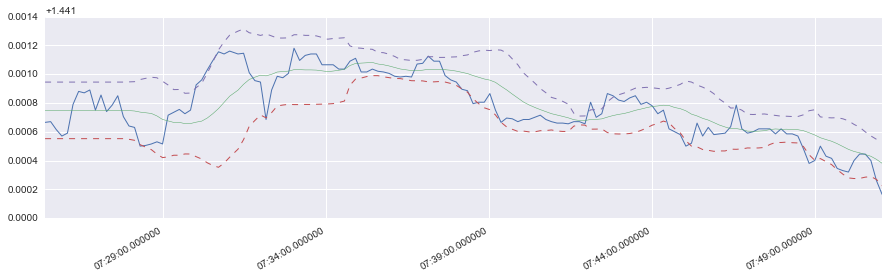

In [6]:
plt.figure(figsize=(15,4))
# bollinger bands
sd = dfdata[target_quote]
sd = sd[-150:]
sdsm = sd.rolling(15).mean()
sdsm.fillna(method='bfill', inplace=True) # fix problem with not enough data on moving average
std = sd.rolling(15).std()
std.fillna(method='bfill', inplace=True) # fix problem with not enough data on moving average
sdmi = sdsm - 1.8*std
sdma = sdsm + 1.8*std
sd.plot(lw=1)
sdsm.plot(lw=0.5)
sdmi.plot(style='--', lw=1)
sdma.plot(style='--', lw=1)

In [7]:
class PreparePredictionData:
    def __init__(self, dfquotes, targetquote, dt=10):
        self.targetquote = targetquote
        self.dfquotes = dfquotes
        self.srtarget = dfquotes[target_quote] # target serie
        self.dt = pd.Timedelta(dt, unit='s') # sampling rate in seconds
        self.bkquotes = dfquotes.copy()
        self.time_index = self.bkquotes.index
    
    def viewquote(self, quote=-1):
        if quote == -1:
            quote = self.targetquote
        pyplot.figure(figsize(15,3))
        self.dfquotes[self.targetquote].plot()
        # store this serie for use at the end
        
    def create_binary_zig_zag_class_sm(self, span=10, smooth=3, plot=True):
        
        self.srpivots = rfforex.create_binary_zig_zag_class_sm(
            self.dfquotes, self.targetquote, span, smooth, plot=plot)
        # create the binary classification class "du" withoutshift (down/up - 0/1)
        self.srdu = self.dfquotes['du'] # save a copy for future use
        
        # create statistics of ups/downs, find p90 and p50
        # calculate delta times for statistics
        deltas = pd.Series([self.srpivots.index[i+1]-self.srpivots.index[i] 
                            for i in range(self.srpivots.index.size-1)])
        # convert to minutes
        deltas = deltas.apply(lambda x : x.total_seconds()/60.)         
            
        # the best found distribution function is a exponential
        shape, loc = stats.expon.fit(deltas.values)
        xmax = stats.expon.ppf(0.9999, shape, loc)
        self.percentiles = stats.expon.ppf([0.01, 0.05, 0.10, 0.45, 0.5, 0.99], shape, loc)
        
        if plot:
            plt.figure(figsize=(8,3))
            nna = plt.hist(deltas.values, bins=30, normed=True);
            plt.plot(np.arange(0, xmax, 0.01), stats.expon.pdf(np.arange(0, xmax, 0.01), shape, loc))
            plt.xlim(0, xmax)
            print("zig zag times << 1% 5% 10% 45% 50% 99% ")
            np.set_printoptions(precision=2)
            # store percentiles for future use            
            print(self.percentiles)
            print("90 percent data trends with length P90 > %.2f minutes"%(self.percentiles[2]))
        
    def create_binary_zig_zag_class(self, ptsvariation, plot=True, lasttrend=False):
        self.srpivots = rfforex.create_binary_zig_zag_class(
            self.dfquotes, self.targetquote, ptsvariation, plot=plot, lasttrend=lasttrend)
        # create the binary classification class "du" withoutshift (down/up - 0/1)
        self.srdu = self.dfquotes['du'] # save a copy for future use
        
        # create statistics of ups/downs, find p90 and p50
        # calculate delta times for statistics
        deltas = pd.Series([self.srpivots.index[i+1]-self.srpivots.index[i] 
                            for i in range(self.srpivots.index.size-1)])
        # convert to minutes
        deltas = deltas.apply(lambda x : x.total_seconds()/60.) 
        
            
        # the best found distribution function is a exponential
        shape, loc = stats.expon.fit(deltas.values)
        xmax = stats.expon.ppf(0.9999, shape, loc)
        self.percentiles = stats.expon.ppf([0.01, 0.05, 0.10, 0.45, 0.5, 0.99], shape, loc)
        
        if plot:
            plt.figure(figsize=(8,3))
            nna = plt.hist(deltas.values, bins=30, normed=True);
            plt.plot(np.arange(0, xmax, 0.01), stats.expon.pdf(np.arange(0, xmax, 0.01), shape, loc))
            plt.xlim(0, xmax)
            print("zig zag times << 1% 5% 10% 45% 50% 99% ")
            np.set_printoptions(precision=2)
            # store percentiles for future use            
            print(self.percentiles)
            print("90 percent data trends with length P90 > %.2f minutes"%(self.percentiles[2]))
        
    def make_shifted_binary_zig_zag_class(self, shift=-1, plot=True):
        # for prediction shift samples to left
        # samples that cannot be used for training are 
        # set NAN. Those samples correlate to future times 
        # we dont know YET that we will predict then
        if shift == -1: # use default based on pivots distribution statics in time
            # percentiles[2] provite minimum needed time from 
            # pivots define up/down change of trend
            # I can only buy IQ option in pratical 2 minutes from last prediction
            delta_buy = 2*60 # also consider it
            shift = delta_buy+self.percentiles[2]*60.
            shift = int(np.ceil(shift/self.dt.total_seconds())) 
            
        if plot:
            print('number of samples shifted ', shift)
            print('shift %.1f (seconds)'%(shift*self.dt.total_seconds()))
        
        self.shift = shift
        # create the binary classification class "du" with shift (down/up - 0/1)        
        self.srdup = rfforex.make_shift_binary_class(self.dfquotes, self.shift, plot=plot) 
        # store some new stuff
        # time of the last valid sample for traininig
        # and last sample recorded
        self.time_index_training = self.srdup.dropna(inplace=False).index  
        self.last_time_real = self.srdup.index[-1] 
        self.last_time_training = self.srdup.dropna(inplace=False).index[-1] 
    
    def create_indicatores(self):
        # remove the target_quote/target_variable and create many indicators
        # can improve here with new indicators, RSI discrete
        rfforex.create_indicators(self.dfquotes, self.targetquote)
        
    def normalize(self):
        # normalize 0 to 1
        self.dfquotes = self.dfquotes.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
        
    def calculate_corr_and_remove(self, verbose=True):
        # print 
        # 5 first and 5 last correlations
        # calculate correlation with class to predict remove < 5% correlation
        rfforex.calculate_corr_and_remove(self.dfquotes, self.srdup, verbose=verbose)
    
    def prepare_training(self):
        # remove time index to make it possible through sckit-learn
        self.dfquotes.reset_index(inplace=True, drop=True)
        self.srdup.reset_index(inplace=True, drop=True)
        self.dfquotes['target_variable_dup'] = pd.Series(self.srdup, 
                                                         index=self.dfquotes.index)
        #print(self.dfquotes.head(1))
        # separate data for prediction and for training
        self.topredict = self.dfquotes[ pd.isnull(self.dfquotes['target_variable_dup']) ]         
        self.dfquotes.dropna(inplace=True)
        self.topredict = self.topredict.copy() # avoid stupid warning from pandas
        self.topredict.drop('target_variable_dup', axis='columns', inplace=True)
        # two groups of vectors training and prediction
        Xtrain, ytrain = rfforex.prepareDataForClassification(self.dfquotes) 
        return Xtrain, ytrain, self.topredict       

zig zag times << 1% 5% 10% 45% 50% 99% 
[  1.09   1.32   1.62   4.38   4.92  26.87]
90 percent data trends with length P90 > 1.62 minutes
number of samples shifted  4
shift 240.0 (seconds)


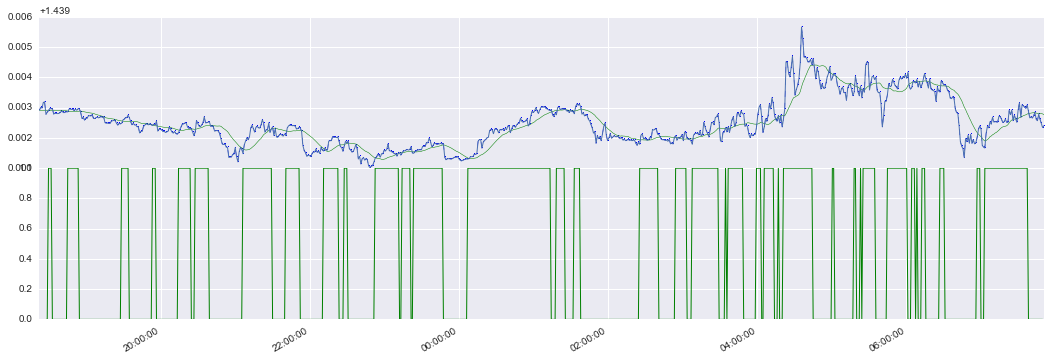

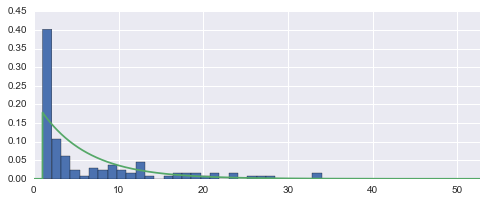

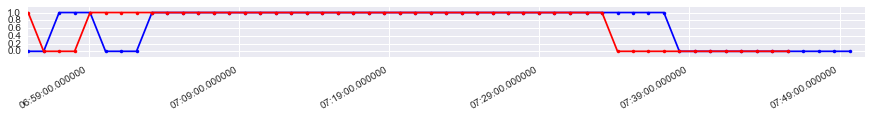

In [34]:
cp  = dfdata[::6] # 30 or 60 seconds
cp = cp.copy() # avoid stupid warning from pandas
#cp = cp.ewm(span=6).mean() # média de 1 minuto
pp = PreparePredictionData(cp, target_quote, dt=60)
#pp.viewquote()
pp.create_binary_zig_zag_class_sm(20, smooth=3)
pp.make_shifted_binary_zig_zag_class()

In [11]:
pp.create_indicatores()
pp.normalize()
pp.calculate_corr_and_remove()
Xtrain, ytrain, Xpredict = pp.prepare_training()

rsi_30 EUR/USD    0.270362
rsi_10 EUR/USD    0.270362
rsi_20 EUR/GBP    0.249919
macd EUR/USD      0.247708
rsi_20 EUR/USD    0.242577
Name: target_variable_dup, dtype: float64
ema_3 EUR/CHF        0.001679
macd_tiny EUR/CHF    0.000642
ema_10 EUR/CHF       0.000625
ema_2 EUR/CHF        0.000331
ema_15 EUR/CHF       0.000074
Name: target_variable_dup, dtype: float64


In [23]:
#pp.dfquotes.ne

In [12]:
class classifier_training:
    def __init__(self):
        pass
        
    def quickLookAnalysisTraining(self, X, y, shift, windown=60, nanalysis=-1):
        self.shift = shift
        self.windown = windown        
        accuracies, model = rfforex.performQuickTrainigAnalysis(X, y, shift, 
                                                                windown=windown, nanalysis=nanalysis)
        self.model = model
        self.accuracies = accuracies
        print("mean accuracy %", 100*np.mean(self.accuracies[1]))
    
    def viewquickLookAnalysis(self, time_index_training):
        
        accuracies_index = np.array([time_index_training[i] for i in self.accuracies[0]])
        pdaccuracies = pd.DataFrame(self.accuracies[1], columns=['accuracy'],
                        index=accuracies_index)
        fig, axr = pyplot.subplots(1, sharex=True, figsize=(15,4))
        # average 8
        pdaccuracies['mean'] = pdaccuracies.accuracy.ewm(span=8).mean()
        pdaccuracies['perc45'] = pd.Series(np.ones(self.accuracies[1].size)*0.6897, index=pdaccuracies.index) # 45%
        pdaccuracies['perc70'] = pd.Series(np.ones(self.accuracies[1].size)*0.5882, index=pdaccuracies.index) # 70%
        pdaccuracies['perc80'] = pd.Series(np.ones(self.accuracies[1].size)*0.5556, index=pdaccuracies.index) # 80%
        pdaccuracies.plot(ax=axr, ylim=(-0.5, 1.5), 
                          style=['ok--', 'b-', '--g', '--g', '--r'], xticks=accuracies_index) 
        date_fmt = '%H:%M:%S'
        formatter = dates.DateFormatter(date_fmt)
        axr.xaxis.set_major_formatter(formatter)
        plt.gcf().autofmt_xdate()
        
    def windowAnalysis(self, X, y, shift, windowgenerator, nanalysis=15):
        
        all_accuracies = []        
        for window in windowgenerator:
            self.quickLookAnalysisTraining(X, y, shift, window, nanalysis=nanalysis)            
            all_accuracies.append(np.mean(100*np.mean(self.accuracies[1])))        
        plt.plot(windowgenerator, all_accuracies, 'o-')        
    
    def Train(self, X, y):
        """
        train just if the number of samples are greater/equal minimum
        """
        if X.index.size >= self.windown:
            self.model.fit(X, y, warm_start=True)
            
    def Predict(self, X):
        return self.model.predict(X)

In [13]:
#%%timeit -n 3 -r 1
#60, 120, 240, 480
#70%, 85%, 68%, 82%
#64%, 63%, 61%, 76%
# number of samples used in each training makes a lot of difference (window parameter)
# warm_start=True is complicated got need to study how to increase number of features
# to see if it is worthwhile 
# Can not do continues training, one tree each time FOR NOW

classifier = classifier_training()
classifier.quickLookAnalysisTraining(Xtrain, ytrain, pp.shift, 200, 17)

Size train set:  (774, 157)
samples in each window:  200
number of analysis:  17
percent of data used  96.12403100775194
mean accuracy % 74.5098039216


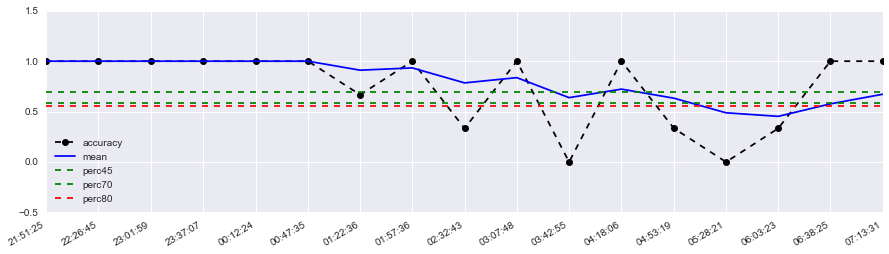

In [14]:
classifier.viewquickLookAnalysis(pp.time_index_training)

In [15]:
print(pp.last_time_training)

2016-06-03 07:45:32.417061


### Create special window do validate training and see if it will go up  or down ###

1. Use the last samples to visually see if it is still predicting correctly
2. Plot over or among the original price chart the predictions

In [29]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

def see_prediction(serie_target, average_delta, serie_pivots, serie_du,
                   clfmodel, data2predict, shift, dt):
    # plot the last samples corresponding to 5 mean zig zag values
    nsee=7
    fig, axr = plt.subplots(2, sharex=True, figsize=(18, 5))
    average_delta = pd.Timedelta(average_delta, unit='s') # FROM sampling rate in seconds
    serie_target[ serie_target.index > (serie_target.index[-1] - average_delta*nsee) ].plot(ax=axr[0])
    selection = serie_pivots[ serie_pivots.index > (serie_pivots.index[-1] - average_delta*nsee) ]
    serie_target[selection.index].plot(ax=axr[0], style='ok--')
    serie_du[serie_du.index > (serie_du.index[-1] - average_delta*nsee)].plot(ax=axr[1], style='.k')
    # prediction        
    # original position of the predictor sample
    serie_prediction_orig = pd.Series(np.ones(data2predict.index.size)*0.5, 
                                      index=serie_target.index[data2predict.index]) 
    serie_prediction_orig.plot(ax=axr[1], style='.g')
    
    # those are predictions need to have the corresponding shift in time
    fst_predict_time = serie_target.index[data2predict.index[0]]+dt*shift
    serie_prediction = pd.Series(clfmodel.predict(data2predict), 
                                 index=pd.date_range(fst_predict_time, 
                                                     periods=data2predict.index.size, freq=dt))
    # format x axis tick labels
    all_ticks = serie_prediction.index.union(selection.index)[::1]
    serie_prediction.plot(ax=axr[1], style='.g-', xticks=all_ticks)
    date_fmt = '%H:%M:%S'
    formatter = dates.DateFormatter(date_fmt)
    axr[1].xaxis.set_major_formatter(formatter)
    plt.gcf().autofmt_xdate()
    #print(serie_prediction.values)
    #ax.axvline(pd.to_datetime('2015-11-01'), color='r', linestyle='--', lw=2)
    #ax.axvline(pd.to_datetime('2015-11-01'), color='r', linestyle='--', lw=2)

In [30]:
pp.topredict

,EUR/USD,AUD/USD,EUR/GBP,USD/CAD,EUR/AUD,AUD/JPY,ema_2 EUR/USD,dema_3 EUR/USD,dema_5 EUR/USD,dema_10 EUR/USD,...,rsi_2 GBP/JPY,rsi_3 GBP/JPY,rsi_5 GBP/JPY,EUR/USD+AUD/USD,AUD/USD+EUR/GBP,EUR/GBP+USD/CHF,USD/CHF+USD/CAD,USD/CAD+EUR/CHF,EUR/CHF+EUR/AUD,AUD/JPY+USD/NOK
0,0.788969,0.212791,0.645233,0.761827,0.828186,0.332265,0.807476,0.504694,0.492860,0.482492,...,1.000000,1.000000,1.000000,0.277197,0.182768,0.408714,0.477979,0.745731,0.813579,0.342457
777,0.122302,0.525581,0.266075,0.546493,0.279618,0.737179,0.094265,0.653848,0.640825,0.605717,...,0.756144,0.685817,0.632165,0.267782,0.310705,0.717842,0.721503,0.629981,0.292290,0.146191
778,0.146283,0.519767,0.305987,0.544861,0.291409,0.744658,0.123904,0.637470,0.646199,0.630687,...,0.754994,0.685429,0.632004,0.273013,0.327676,0.719917,0.698187,0.620493,0.302071,0.126459
779,0.129496,0.437209,0.328160,0.603589,0.372263,0.638889,0.122139,0.530343,0.556799,0.570580,...,0.036572,0.116719,0.238943,0.191423,0.248042,0.755187,0.753886,0.688805,0.384925,0.258010
780,0.119904,0.439535,0.350333,0.597064,0.369455,0.649573,0.114896,0.494239,0.513608,0.535615,...,0.009491,0.043903,0.123650,0.189331,0.263708,0.788382,0.756477,0.683112,0.382624,0.280713
781,0.136691,0.458140,0.350333,0.557912,0.353734,0.688034,0.124127,0.540206,0.544979,0.559118,...,0.692573,0.574689,0.491653,0.213389,0.284595,0.775934,0.717617,0.641366,0.367664,0.274135


2016-06-03 07:50:41.958772


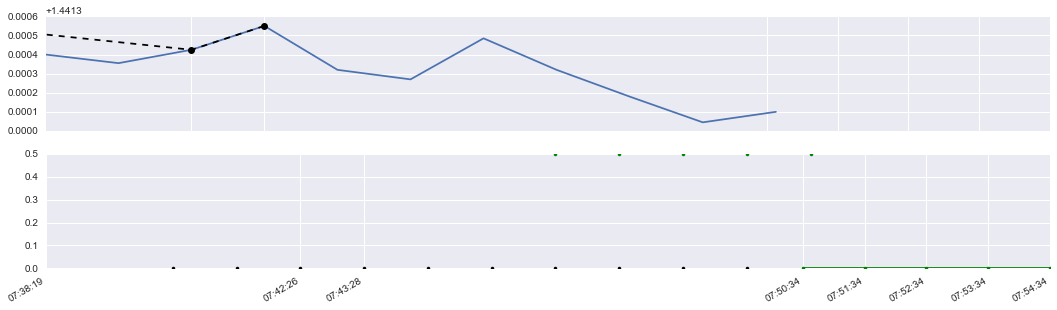

In [31]:
see_prediction(pp.srtarget, pp.percentiles[2]*60., pp.srpivots, pp.srdu,
               classifier.model, pp.topredict[1:], pp.shift, pp.dt)

print(pp.last_time_real)

In [39]:
# vou criando amostras de 15 em 15
###  treinando de 60 em 60  bla bla bla bla
# predizendo de 15 em 15 e apostando
# só posso comprar na prática 1 minutos depois da última amostra
# vamos apostar no turbo 2 minutos de duração

# remover todas prediçoes menores que 5%

# vou apostar em quantos minutos?
# fitar variações de preço baseado na aposta que quero fazer.
# se for turbo 1, 2, 3, 4 e 5 minutos
# binary 15, 30, 60, 90, 120, 180, 240 etc minutos

In [47]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

iqbuy = []
dcp  = dfdata[::6] # 60 seconds
dcp = dcp.copy()

for i in range(200, 430, 1): # 10*30 = 300 s = 5 minutos
    cp  = dcp[:i]
    cp = cp.copy() # avoid stupid warning from pandas
    #cp = cp.ewm(span=6).mean() # média de 1 minuto
    pp = PreparePredictionData(cp, target_quote, dt=30)
    #pp.viewquote()
    pp.create_binary_zig_zag_class(0.0005, lasttrend=True, plot=False)
    pp.make_shifted_binary_zig_zag_class(shift=15, plot=False)
    pp.create_indicatores()
    pp.normalize()
    pp.calculate_corr_and_remove(verbose=False)
    Xtrain, ytrain, Xpredict = pp.prepare_training()

    clfmodel = ExtraTreesClassifier(n_estimators=900, n_jobs=-1)
    clfmodel.fit(Xtrain.tail(200), ytrain.tail(200))
    prediction = clfmodel.predict(pp.topredict)
    # + 1 minute = 1 samples
    # buy time value index median
    # end time value index 2 minutes = 12 samples

    iqbuy.append({"buyindex": pp.topredict.index[-1]+1, 
                  "updown" : np.median(prediction[:]), 
                  "endindex" : pp.topredict.index[-1]+14})

In [48]:
iqdf = pd.DataFrame(iqbuy)

In [49]:
iqdf.columns

Index(['buyindex', 'endindex', 'updown'], dtype='object')

In [50]:
iqdf['buyvalue'] = dfdata[pp.targetquote][ dfdata.index[ iqdf['buyindex'] ]].values[:]
iqdf['endvalue'] = dfdata[pp.targetquote][ dfdata.index[ iqdf['endindex'] ]].values[:]
iqdf.drop(iqdf[ (iqdf['endvalue'] == iqdf['buyvalue'])  ].index , axis=0, inplace=True) # no win no loss
iqdf['realup'] = iqdf['endvalue'] - iqdf['buyvalue']
iqdf['bup'] = iqdf['realup'].apply(lambda x: 1 if x > 0 else 0)
#iqdf['bup'] = iqdf['realup'].apply(lambda x: np.nan if x == 0)

In [51]:
iqdf['right'] = (iqdf['bup'] == iqdf['updown'])
print(iqdf[iqdf['right'] == True].index.size)
print(iqdf[iqdf['right'] == False].index.size)
print(100*((iqdf[iqdf['right'] == True].index.size)/iqdf.index.size))

9
21
30.0


In [53]:
iqdf

,buyindex,endindex,updown,buyvalue,endvalue,realup,bup,right
0,400,413,1.0,1.441640,1.441665,0.000025,1,True
1,401,414,1.0,1.441670,1.441750,0.000080,1,True
2,402,415,1.0,1.441670,1.441860,0.000190,1,True
3,403,416,1.0,1.441650,1.442015,0.000365,1,True
4,404,417,1.0,1.441650,1.441675,0.000025,1,True
5,405,418,1.0,1.441650,1.441670,0.000020,1,True
6,406,419,1.0,1.441645,1.441660,0.000015,1,True
7,407,420,1.0,1.441665,1.441670,0.000005,1,True
8,408,421,1.0,1.441670,1.441655,-0.000015,0,False
9,409,422,1.0,1.441670,1.441675,0.000005,1,True


In [97]:
from itertools import islice

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n: # size n window equal window
        yield result    
    for elem in it:
        result = result[1:] + (elem,)
        yield result
        
x = np.random.randint(0, 2, 10)
print(x)
print('after')
for i in window(x, n=3):
    mode = stats.mode(i)[0][0]
    if np.size(i) == np.size(np.unique(i)):
        print(i[0])
    else:
        print(counts)

[0 0 1 0 1 1 0 0 1 0]
after
0
0
0
0
0
0
0
0
